In [1]:
include("spiking.jl")

train_to_phase (generic function with 2 methods)

In [28]:
using Plots

In [3]:
phase = rand(Float32, 128, 100) .* 2 .- 1

128×100 Matrix{Float32}:
  0.800246    0.933885   -0.804093    …  -0.34884     0.404555     0.647823
  0.619436   -0.782038   -0.429967        0.368385   -0.00932872   0.443229
 -0.333164    0.756799    0.093436       -0.921406    0.33395      0.401574
  0.681392    0.924626   -0.124279       -0.480629    0.255467    -0.359679
  0.364274   -0.683604   -0.59826        -0.27461    -0.709425     0.659657
 -0.163485   -0.965461   -0.657007    …   0.0659546  -0.863617     0.416005
 -0.7411      0.256742   -0.074209       -0.269302    0.900505    -0.315009
 -0.161535    0.606327    0.659959       -0.161924    0.97727     -0.0128369
  0.0174018   0.766933    0.116691       -0.314689    0.00288391  -0.488868
 -0.656723   -0.457251   -0.290799        0.893979   -0.936573    -0.378851
  ⋮                                   ⋱                           
  0.684229   -0.0348475  -0.696365        0.910874    0.62561     -0.134124
 -0.362178    0.652725    0.893654    …   0.285187    0.320568     0.50

In [5]:
spk_args = default_spk_args()

SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05)

In [23]:
function phase_to_train(phases::AbstractMatrix, spk_args::SpikingArgs, repeats::Int = 1, offset::Real = 0.0)
    t_phase0 = spk_args.t_period / 2.0
    shape = phases |> size

    phases = phases |> vec

    indices = collect(1:length(phases))
    times = phases .* t_phase0 .+ t_phase0

    if repeats > 1
        n_t = times |> length
        offsets = repeat(0:repeats-1, inner=n_t)
        times = repeat(times, repeats) .+ offsets
        indices = repeat(indices, repeats)
    end

    train = SpikeTrain(indices, times, shape, offset)
    return train
end

phase_to_train (generic function with 3 methods)

In [24]:
st = phase_to_train(phase, spk_args, 2, 0.0)

SpikeTrain([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800], [0.900122880935669, 0.8097177743911743, 0.3334178328514099, 0.8406957983970642, 0.6821368932723999, 0.41825753450393677, 0.1294499635696411, 0.4192326068878174, 0.5087009072303772, 0.1716386079788208  …  1.432332456111908, 1.4329380989074707, 1.7537143230438232, 1.2712976932525635, 1.560242772102356, 1.0583893656730652, 1.2655309438705444, 1.4460021257400513, 1.1891489028930664, 1.3938452005386353], (128, 100), 0.0)

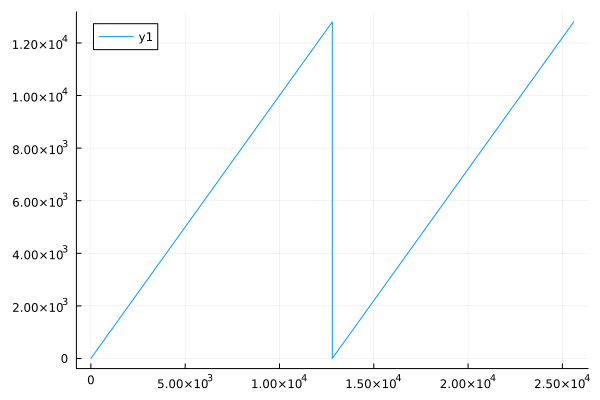

In [29]:
plot(st.indices)

In [26]:
st.indices

25600-element Vector{Int64}:
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
     ⋮
 12792
 12793
 12794
 12795
 12796
 12797
 12798
 12799
 12800

In [103]:
function time_to_phase(times::AbstractVecOrMat, period::Real, offset::Real)
    times = (times .- offset) .% period
    times = (times .- 0.5) .* 2.0
    return times
end

function train_to_phase(train::SpikeTrain, spk_args::SpikingArgs)
    if length(train.times) == 0
        return missing
    end

    phases_vec = time_to_phase(train.times, spk_args.t_period, train.offset)
    n_cycles = maximum(train.times) ÷ spk_args.t_period + 1
    cycle = floor.(Int, train.times .÷ spk_args.t_period .+ 1)
    phases = [NaN .* zeros(train.shape...) for i in 1:n_cycles]

    for i in eachindex(phases_vec)
        phases[cycle[i]][train.indices[i]] = phases_vec[i]
    end

    #stack the arrays
    phases = mapreduce(x->reshape(x, 1, st.shape...), vcat, phases)
    phases = permutedims(phases, (2, 3, 1))
    return phases

end

train_to_phase (generic function with 2 methods)

In [104]:
c = train_to_phase(st, spk_args)

128×100×2 Array{Float64, 3}:
[:, :, 1] =
  0.800246    0.933885   -0.804093    …  -0.34884     0.404555     0.647823
  0.619436   -0.782038   -0.429967        0.368385   -0.00932872   0.443229
 -0.333164    0.756799    0.093436       -0.921406    0.33395      0.401574
  0.681392    0.924626   -0.124279       -0.480629    0.255467    -0.359679
  0.364274   -0.683604   -0.59826        -0.27461    -0.709425     0.659657
 -0.163485   -0.965461   -0.657007    …   0.0659546  -0.863617     0.416005
 -0.7411      0.256742   -0.074209       -0.269302    0.900505    -0.315009
 -0.161535    0.606327    0.659959       -0.161924    0.97727     -0.0128369
  0.0174018   0.766933    0.116691       -0.314689    0.00288391  -0.488868
 -0.656723   -0.457251   -0.290799        0.893979   -0.936573    -0.378851
  ⋮                                   ⋱                           
  0.684229   -0.0348475  -0.696365        0.910874    0.62561     -0.134124
 -0.362178    0.652725    0.893654    …   0.285187    0

In [107]:
c

128×100×2 Array{Float64, 3}:
[:, :, 1] =
  0.800246    0.933885   -0.804093    …  -0.34884     0.404555     0.647823
  0.619436   -0.782038   -0.429967        0.368385   -0.00932872   0.443229
 -0.333164    0.756799    0.093436       -0.921406    0.33395      0.401574
  0.681392    0.924626   -0.124279       -0.480629    0.255467    -0.359679
  0.364274   -0.683604   -0.59826        -0.27461    -0.709425     0.659657
 -0.163485   -0.965461   -0.657007    …   0.0659546  -0.863617     0.416005
 -0.7411      0.256742   -0.074209       -0.269302    0.900505    -0.315009
 -0.161535    0.606327    0.659959       -0.161924    0.97727     -0.0128369
  0.0174018   0.766933    0.116691       -0.314689    0.00288391  -0.488868
 -0.656723   -0.457251   -0.290799        0.893979   -0.936573    -0.378851
  ⋮                                   ⋱                           
  0.684229   -0.0348475  -0.696365        0.910874    0.62561     -0.134124
 -0.362178    0.652725    0.893654    …   0.285187    0

In [106]:
c[:,:,1] .== c[:,:,2]

128×100 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  

In [109]:
phase .== c[:,:,1]

128×100 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  